In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
import xgboost
from sklearn.model_selection import GridSearchCV

In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'
FEATURES_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck_features'

# --- GOAL: Binary Classification (OSA vs. NORMAL) ---
# We group all events related to obstructive respiratory issues into a single 'OSA' class.
EVENT_MAPPINGS = {
    'OSA': ['Obstructive Apnea', 'Obstructive Hypopnea', 'Hypopnea', 'RERA']
}

# Create a reverse mapping for quick lookup
event_to_class = {}
for class_name, events in EVENT_MAPPINGS.items():
    for event in events:
        event_to_class[event] = class_name

# Define a simple binary numeric mapping
class_to_numeric = {
    'NORMAL': 0,
    'OSA': 1,
}

# Create reverse mapping for reading results later
numeric_to_class = {v: k for k, v in class_to_numeric.items()}

all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'.")

print(f"Found {len(event_files)} event files. Processing each one for BINARY classification...")

for event_file_path in event_files:
    # --- 1. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    nasal_file_path = os.path.join(NASAL_FOLDER, f'{session_id}_nasal.csv')
    feature_file_path = os.path.join(FEATURES_FOLDER, f'{session_id}_respeck_features.csv')
    
    if not all(os.path.exists(p) for p in [respeck_file_path, nasal_file_path, feature_file_path]):
        print(f"  - WARNING: Skipping session '{session_id}'. A corresponding file is missing.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2. Load all data sources ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_nasal = pd.read_csv(nasal_file_path)
    df_respeck = pd.read_csv(respeck_file_path)
    df_features = pd.read_csv(feature_file_path)

    # --- 3. Standardize timestamp columns and types ---
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_nasal.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True, errors='ignore')
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype(int)

    df_features['timestamp_unix'] = pd.to_datetime(df_features['startTimestamp'], format="mixed")
    df_features['timestamp_unix'] = df_features['timestamp_unix'].astype('int64') // 10**6
    
    df_features['timestamp_unix_end'] = pd.to_datetime(df_features['endTimestamp'], format="mixed")
    df_features['timestamp_unix_end'] = df_features['timestamp_unix_end'].astype('int64') // 10**6
    
    # --- 4. Calculate the true overlapping time range ---
    start_time = max(df_nasal['timestamp_unix'].min(), df_respeck['timestamp_unix'].min())
    end_time = min(df_nasal['timestamp_unix'].max(), df_respeck['timestamp_unix'].max())
    
    # --- 5. Trim Respeck data to the overlapping time range ---
    df_respeck = df_respeck[(df_respeck['timestamp_unix'] >= start_time) & (df_respeck['timestamp_unix'] <= end_time)].copy()

    if df_respeck.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No Respeck data in the overlapping range.")
        continue

    print("  - Preparing and merging engineered features...")
    df_respeck = df_respeck.sort_values('timestamp_unix')
    df_features = df_features.sort_values('timestamp_unix')

    df_session_merged = pd.merge_asof(
        df_respeck, df_features, on='timestamp_unix', direction='backward'
    )
    cols_to_drop = ['Unnamed: 0','startTimestamp', 'endTimestamp', 'timestamp_unix_end']
    df_session_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    if df_session_merged.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No merge matches found.")
        continue
        
    # --- 6. SIMPLIFIED: Binary Interval-Based Labeling ---
    df_session_merged['Label'] = 0
    df_session_merged['Label_Name'] = 'NORMAL'
    
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
        
    for index, event in df_events.iterrows():
        event_type = event['Event']
        
        # Check if the event is in our 'OSA' mapping
        if event_type in event_to_class:
            start_event = event['timestamp_unix']
            end_event = event['end_time_unix']
            
            mask = df_session_merged['timestamp_unix'].between(start_event, end_event)
            df_session_merged.loc[mask, 'Label'] = 1 # OSA
            df_session_merged.loc[mask, 'Label_Name'] = 'OSA'
    
    # --- 7. Finalize session data ---
    df_session_merged['SessionID'] = session_id
    all_sessions_df_list.append(df_session_merged)
    
# --- Combine all nights and perform final processing ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was loaded.")

df = pd.concat(all_sessions_df_list, ignore_index=True)

print("\n----------------------------------------------------")
print("Data loading with BINARY interval labeling complete.")
print(f"Final DataFrame shape: {df.shape}")
print(f"\nFinal class distribution in raw data:")
print(df['Label_Name'].value_counts())

Found 9 event files. Processing each one for BINARY classification...
  - Processing session: 26-04-2025
  - Preparing and merging engineered features...
  - Processing session: 08-05-2025
  - Preparing and merging engineered features...
  - Processing session: 05-04-2025
  - Preparing and merging engineered features...
  - Processing session: 10-05-2025
  - Preparing and merging engineered features...
  - Processing session: 24-04-2025
  - Preparing and merging engineered features...
  - Processing session: 25-04-2025
  - Preparing and merging engineered features...
  - Processing session: 16-04-2025
  - Preparing and merging engineered features...
  - Processing session: 11-05-2025
  - Preparing and merging engineered features...
  - Processing session: 04-04-2025
  - Preparing and merging engineered features...

----------------------------------------------------
Data loading with BINARY interval labeling complete.
Final DataFrame shape: (2139235, 31)

Final class distribution in r

In [3]:
# Windowing: Creating the time-series segments.
print(df.columns)

SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)

# Step size for sliding window. An 80% overlap is a good start.
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

# === Data Parameters ===
FEATURE_COLUMNS = [
    'breathingSignal', 
    'activityLevel',
    'peakRespiratoryFlow', 
    'breath_regularity',
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'


TEST_NIGHTS = 2
TOTAL_NIGHTS = 9 
TEST_SIZE = TEST_NIGHTS / TOTAL_NIGHTS

RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

Index(['timestamp_unix', 'timestamp', 'interpolatedPhoneTimestamp',
       'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal',
       'breathingRate', 'activityLevel', 'activityType', 'type', 'area',
       'extremas', 'meanActivityLevel', 'modeActivityType',
       'peakRespiratoryFlow', 'duration', 'BR_md', 'BR_mean', 'BR_std',
       'AL_md', 'AL_mean', 'AL_std', 'RRV', 'RRV3MA', 'breath_regularity',
       'Label', 'Label_Name', 'SessionID'],
      dtype='object')


In [4]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...
  - Found 4630 NaNs in 'breathingSignal'. Applying forward-fill and backward-fill.
  - Found 2097749 NaNs in 'breathingRate'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'type'. Applying forward-fill and backward-fill.


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_19357/370400962.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].ffill(inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_19357/370400962.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


  - Found 4688 NaNs in 'area'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'extremas'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'meanActivityLevel'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'modeActivityType'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'peakRespiratoryFlow'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'duration'. Applying forward-fill and backward-fill.
  - Found 7179 NaNs in 'BR_md'. Applying forward-fill and backward-fill.
  - Found 7179 NaNs in 'BR_mean'. Applying forward-fill and backward-fill.
  - Found 22762 NaNs in 'BR_std'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'AL_md'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'AL_mean'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'AL_std'. Applying forward-fill and backward-fill.
  - Found 4688 NaNs in 'RRV'. Applying forward-fill and backward-fill.
  - 

In [5]:
X = []
y = []
groups = [] 

print("Starting the BINARY windowing process...")

# --- Loop through each session (night) to create windows ---
for session_id, session_df in df.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        
        # Extract features for the window
        features = window_df[FEATURE_COLUMNS].values
        
        # --- SIMPLIFIED BINARY LABELING LOGIC ---
        # If any data point in the window is labeled as OSA (1), the entire window is OSA.
        # Otherwise, the window is NORMAL (0).
        if (window_df[LABEL_COLUMN] == 1).any():
            label = 1
        else:
            label = 0
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

# --- Convert the lists into efficient NumPy arrays ---
X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

# --- Print a summary of the results ---
print("\nBinary data windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Window_Size, Num_Features)")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"\nFinal Windowed Class Distribution: {Counter(y)} (0=NORMAL, 1=OSA)")

Starting the BINARY windowing process...

Binary data windowing complete.
----------------------------------------------------
Shape of X (features): (28868, 375, 4) -> (Num_Windows, Window_Size, Num_Features)
Shape of y (labels):   (28868,)
Shape of groups (IDs): (28868,)

Final Windowed Class Distribution: Counter({np.int64(0): 24750, np.int64(1): 4118}) (0=NORMAL, 1=OSA)


In [6]:
unique_session_ids = np.unique(groups)
n_total_sessions = len(unique_session_ids)

print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

Found 9 unique sessions (nights) in the dataset: ['04-04-2025' '05-04-2025' '08-05-2025' '10-05-2025' '11-05-2025'
 '16-04-2025' '24-04-2025' '25-04-2025' '26-04-2025']


In [7]:
# # Splitting dataset

# unique_session_ids = np.unique(groups)
# n_total_sessions = len(unique_session_ids)

# print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

# train_ids, test_ids = train_test_split(
#     unique_session_ids, 
#     test_size=TEST_NIGHTS, 
#     random_state=RANDOM_STATE
# )
# print(f"\nSplitting data into training and testing sets...")
# print(f"  - Sessions assigned to TRAINING set: {train_ids}")
# print(f"  - Sessions assigned to TESTING set:  {test_ids}")

# train_mask = np.isin(groups, train_ids)
# test_mask = np.isin(groups, test_ids)

# # --- 4. Apply the masks to create the final data sets ---
# X_train, y_train = X[train_mask], y[train_mask]
# X_test, y_test = X[test_mask], y[test_mask]

# # --- 5. Verify the results ---
# print("\nTrain-test split complete.")
# print("----------------------------------------------------")
# print(f"Total windows in training set:   {len(X_train)}")
# print(f"Total windows in testing set:    {len(X_test)}")
# print(f"Shape of X_train:                {X_train.shape}")
# print(f"Shape of X_test:                 {X_test.shape}")
# print(f"Training set class distribution: {Counter(y_train)} (0=Normal, 1=Apnea)")
# print(f"Testing set class distribution:  {Counter(y_test)} (0=Normal, 1=Apnea)")

In [8]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps



Starting XGBoost Leave-One-Night-Out cross-validation with 9 folds...
----------------------------------------------------

--- FOLD 1/9 ---
Testing on Night: 04-04-2025

  - Original training distribution: Counter({np.int64(0): 21630, np.int64(1): 3687})
  - Resampled training distribution: Counter({np.int64(0): 21630, np.int64(1): 21630})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 1.

--- FOLD 2/9 ---
Testing on Night: 05-04-2025

  - Original training distribution: Counter({np.int64(0): 22572, np.int64(1): 3032})
  - Resampled training distribution: Counter({np.int64(0): 22572, np.int64(1): 22572})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 2.

--- FOLD 3/9 ---
Testing on Night: 08-05-2025

  - Original training distribution: Counter({np.int64(0): 21913, np.int64(1): 3550})
  - Resampled training distribution: Counter({np.int64(0): 21913, np.int64(1): 21913})
  - Training XGBoost model...
  - Trai

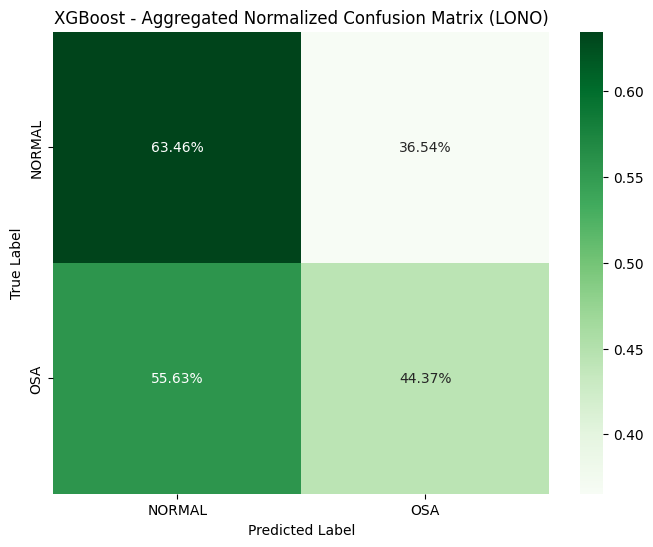

In [9]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For binary classification, our class names are simple
class_names = ['NORMAL', 'OSA']

# Initialize lists to store results from all folds
all_fold_predictions = []
all_fold_true_labels = []

# Setup Leave-One-Night-Out cross-validator
logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
print(f"\nStarting XGBoost Leave-One-Night-Out cross-validation with {n_folds} folds...")
print("----------------------------------------------------\n")

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    test_night = np.unique(groups[test_idx])[0]
    print(f"--- FOLD {fold + 1}/{n_folds} ---")
    print(f"Testing on Night: {test_night}\n")

    # Split the data for this fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # FLATTEN THE DATA for XGBoost
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    X_train_flattened = X_train.reshape(-1, n_timesteps * n_features)
    X_test_flattened = X_test.reshape(-1, n_timesteps * n_features)
    
    # Balance the TRAINING data for this fold using SMOTE
    print(f"  - Original training distribution: {Counter(y_train)}")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)
    print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

    # Initialize and Train a NEW XGBoost model for this fold
    print("  - Training XGBoost model...")
    
    # Configure the model for BINARY classification
    model = xgb.XGBClassifier(
        objective='binary:logistic',  # Use binary logistic regression objective
        eval_metric='logloss',        # Evaluation metric for binary classification
        n_estimators=200,             # Can start with fewer estimators
        learning_rate=0.05,
        max_depth=5,
        # use_label_encoder=False,      # Suppress a deprecation warning
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    model.fit(X_train_resampled, y_train_resampled)
    print(f"  - Training complete.")
            
    # Evaluate the fold and store results
    fold_preds = model.predict(X_test_flattened)
    all_fold_predictions.extend(fold_preds)
    all_fold_true_labels.extend(y_test)
    print(f"  - Evaluation complete for fold {fold + 1}.\n")


# --- FINAL AGGREGATED EVALUATION ---
print("\n====================================================")
print("XGBoost Leave-One-Night-Out Cross-Validation Complete.")
print("Aggregated Results Across All Folds:")
print("====================================================")

# --- Final Classification Report ---
print('\nAggregated Classification Report')
print('------------------------------')
print(classification_report(all_fold_true_labels, all_fold_predictions, target_names=class_names))

# --- Final Confusion Matrix ---
print('\nAggregated Confusion Matrix')
print('---------------------------')
cm = confusion_matrix(all_fold_true_labels, all_fold_predictions)
# Normalize the confusion matrix to show percentages
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = np.where(cm.sum(axis=1)[:, np.newaxis] > 0, cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Greens',
    xticklabels=class_names, yticklabels=class_names
)
plt.title('XGBoost - Aggregated Normalized Confusion Matrix (LONO)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()